In [15]:
 %run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:1,



In [16]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [17]:
#%config Completer.use_jedi = False

import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [18]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

In [19]:
# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [20]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [21]:
(_, _), (x_test, y_test) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(test_neural_data, test_behavioural_data), 
            with_behaviour=False
            )

In [22]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [23]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
None


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [24]:
AP_BITS = 16
AP_INTS = 6

In [25]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits({}, {}, alpha=1)".format(AP_BITS, AP_INTS-1)

# model parameters

In [26]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [27]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x7f3b584e8ee0>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling object at 0x7f3afbf76be0>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x7f3afbf76d60>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f3afbf76dc0>}})


In [28]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f3b584ebe50>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f3afbf76040>}

In [29]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f3afbf76be0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f3afbf76d60>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f3afbf76dc0>,
 'original_cell': False}

In [30]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f3afbf76280>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f3afbf766d0>}

In [31]:
layers_settings['dense_logvar']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f3afbfacfa0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f3b584eb310>}

## function to build the model

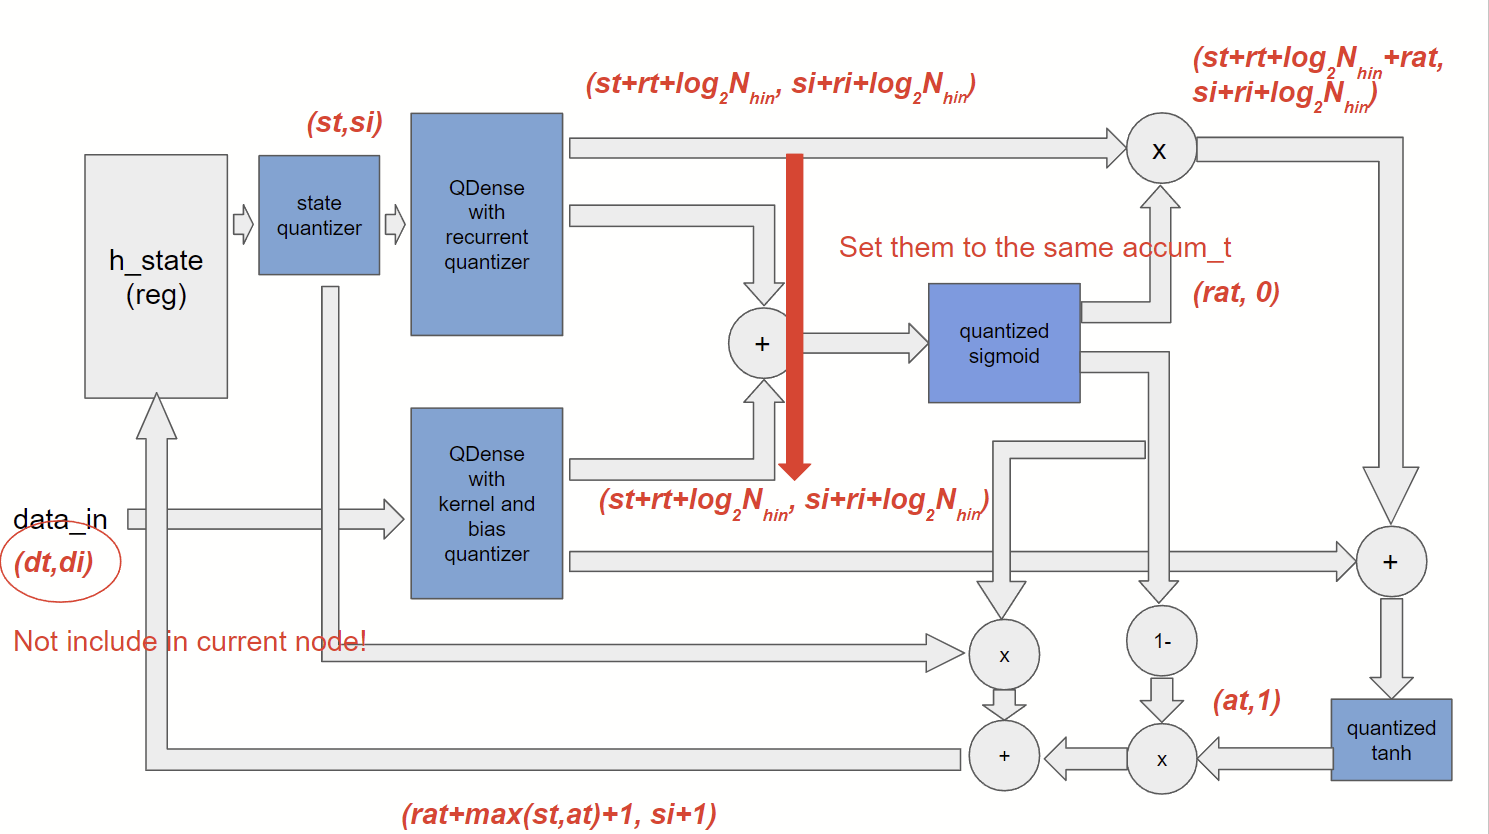

## the ACCUM bits in QGRU is based on the state quantizer, so the previous act_quan precision should be less than it
## here set the state quantizer same as the act_quan

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [32]:
decoder_dim = 64

In [33]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    return inputs2decoder_train, inputs2decoder_val

# Build models

In [34]:
inputs2decoder_train, inputs2decoder_val = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


In [35]:
#pred_val_z, pred_val_logf = fmodel.predict([x_val, inputs2decoder_val])

In [36]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood

In [37]:
#evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

In [38]:
#del fmodel

# loss: poisson_loglike_loss

In [39]:
from tensorflow.keras import backend as K

In [40]:
BATCH_SIZE=16

In [41]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

## Build a fp model and train

In [42]:
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras

In [43]:
class ExponentLogvar(tfl.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        return tf.exp(0.5 * inputs) 

In [44]:
class StandardRandomNormal(tfl.Layer):
    def __init__(self, seed=42, n_samples=4, **kwargs):
        super().__init__()
        self.seed = seed
        self.n_samples = n_samples

    def call(self, inputs):
        return K.random_normal(shape=tf.shape(inputs), mean=0.0, stddev=1.0, seed=self.seed)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
            "seed": self.seed,
            "n_samples":  self.n_samples
            })
        return config                

## Build the encoder

In [45]:
def create_fpencoder(input_shape = (73,70),
                    encoder_dim=64,  
                   drop=dropout
                  ):
    
    # input layer
    inputLayer =  tfl.Input(shape=input_shape, name = 'encoder_input')        
    x = tfl.Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUForward",
            return_state=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            )
    
    backward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUBackward",
            return_state=True, 
            go_backwards=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
             )
                
    x = tfl.Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]  
    
    x = tfl.Dropout(drop, name = 'postencoder_dropout')(x)

    # latent space    
    z_mean = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_mean'
              )(x)
    z_log_var = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_logvar']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_logvar']['kernel_initializer'],
               name='dense_logvar'
              )(x)
    
    # sample 
    # z_mean + tf.exp(0.5 * z_log_var) * epsilon
    epsilon = StandardRandomNormal()(z_mean)
    z_var = ExponentLogvar()(z_log_var)
    z_var = tfl.Multiply()([z_var, epsilon])
    
    z = tfl.Add()([z_mean, z_var])
    
    encoder = Model(inputs = inputLayer, outputs = [z_mean, z_log_var, z], name="encoder")
    
    return encoder
    

In [195]:
encoder = create_fpencoder()

In [196]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [197]:
from tensorflow.keras.utils import plot_model


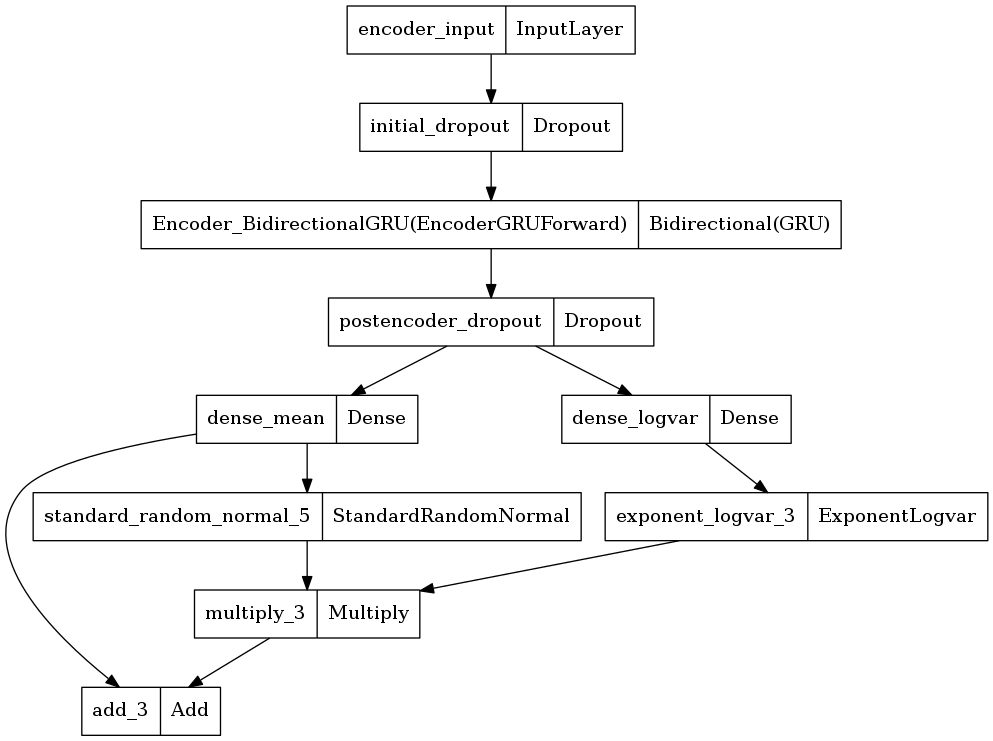

In [198]:
plot_model(encoder)

# Build the decoder

## since the latent vector will become the initial state of the decoder GRU, 
## decoder_dim = latent dimension

In [199]:
decoder_args: Dict[str, Any] = layers_settings['decoder']

In [200]:
del  decoder_args['original_cell']

KeyError: 'original_cell'

In [201]:
def create_fpdecoder(input_shape = (73,70),
                     decoder_dim=decoder_dim,  
                     factors = 4,
                     drop=dropout
                     ):
    
    # decoder
    input_decoder_shape = (input_shape[0], decoder_dim) #( 73 timesteps, 64 decoder_dim)
    input_decoder = tfl.Input(shape=input_decoder_shape, name = 'decoder_input')
    
    # sampled latent 
    latent_inputs = tfl.Input(shape=(decoder_dim,), name = 'latent_input')
        
    x = tfl.GRU(
                decoder_dim,                
                return_sequences=True,
                time_major=False,
                name='DecoderGRU',
        **decoder_args
                )(input_decoder, initial_state = latent_inputs)
    x = tfl.Dropout(drop, name = 'postdecoder_dropout')(x)
    
    # DIMENSIONALITY REDUCTION
    z = tfl.Dense(
            factors, 
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    
    # NEURAL
    neural_dim = input_shape[-1] #70
    
    z = tfl.Dense(
            neural_dim, 
            use_bias=True, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
            name='nerual_dense')(z)
    
    
    decoder = Model(inputs = [latent_inputs, input_decoder], outputs =z , name="decoder")
    
    return decoder
    

In [202]:
decoder = create_fpdecoder()

In [203]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 73, 64)]     0           []                               
                                                                                                  
 latent_input (InputLayer)      [(None, 64)]         0           []                               
                                                                                                  
 DecoderGRU (GRU)               (None, 73, 64)       24960       ['decoder_input[0][0]',          
                                                                  'latent_input[0][0]']           
                                                                                                  
 postdecoder_dropout (Dropout)  (None, 73, 64)       0           ['DecoderGRU[0][0]']       

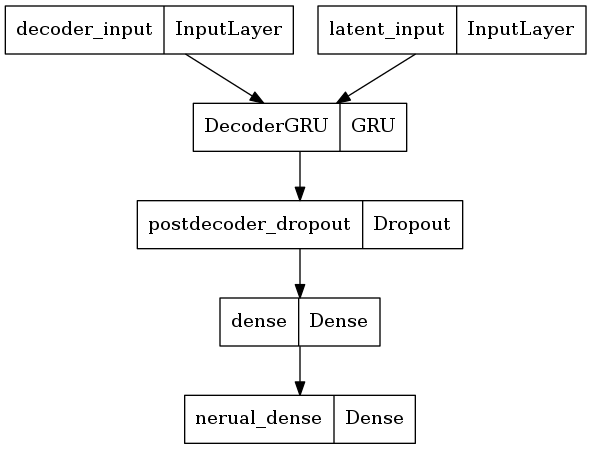

In [204]:
plot_model(decoder)

# combined 

In [205]:
class LFADS(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # loss track
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.poisson_loglike_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Sum(name="reg_loss")
        
        # loss weight track
        self.tracker_loss_w_loglike = keras.metrics.Mean(
            name="loss_w_loglike")
        self.tracker_loss_w_kldiv = keras.metrics.Mean(name="loss_w_kldiv")
        self.tracker_loss_w_reg = keras.metrics.Mean(name="loss_w_reg")
        self.tracker_lr = keras.metrics.Mean(name="lr")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.poisson_loglike_loss_tracker,
            self.kl_loss_tracker,
        ]
    def compile(self, optimizer, loss_weights, *args, **kwargs):
        super(LFADS, self).compile(
            optimizer=optimizer
        )
        self.loss_weights = loss_weights

    def train_step(self, data):

        x, y = data
        x_in, decoder_in = x
        #print(x[0])
        #print(x[1])
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_in)
            reconstruction = self.decoder((z, decoder_in))
            
            pll_loss = poisson_loglike_loss(y, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            reg_loss = tf.reduce_sum(self.losses)

            
            total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss + self.loss_weights[2] * reg_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # metrics
        self.total_loss_tracker.update_state(total_loss)
        self.poisson_loglike_loss_tracker.update_state(pll_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        
        self.tracker_loss_w_loglike.update_state(self.loss_weights[0])
        self.tracker_loss_w_kldiv.update_state(self.loss_weights[1])
        self.tracker_loss_w_reg.update_state(self.loss_weights[2])
        self.tracker_lr.update_state(
            self.optimizer._decayed_lr('float32').numpy())
        
        return {
            "loss": self.total_loss_tracker.result(),
            "pll_loss": self.poisson_loglike_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
            'weights/loglike': self.tracker_loss_w_loglike.result(),
            'weights/kldiv': self.tracker_loss_w_kldiv.result(),
            'weights/reg': self.tracker_loss_w_reg.result(),
            'learning_rate': self.tracker_lr.result()
        }
            
      
    def test_step(self, data):
        x, y = data
        x_in, decoder_in = x

        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))

        pll_loss = poisson_loglike_loss(y, reconstruction)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = pll_loss + kl_loss
        

            
        total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss

        return {
          "loss": total_loss,
          "pll_loss": pll_loss,
          "kl_loss": kl_loss,
        }
    def call(self, data):
        x_in, decoder_in = data
        
        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))
        
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstruction
        

In [206]:
model = LFADS(encoder, decoder)


# train
## callbacks

In [207]:
from tndm.utils import AdaptiveWeights

In [208]:
adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    )

In [209]:
adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5)

In [210]:
adaptive_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_pll_loss', **adaptive_lr)

In [211]:
csv_logger = tf.keras.callbacks.CSVLogger("guassian_fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "guassian_lfadfp.h5",
    monitor = 'val_pll_loss',
    save_best_only = True,
    save_weights_only= True
)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

#lfadfp_callbacks=[csv_logger, model_check, early]
lfadfp_callbacks=[csv_logger, 
                  model_check, 
                  #early, 
                  adaptive_weights, 
                  adaptive_lr_callback
                 ]

In [212]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08,
global_clipnorm=200 , clipvalue=1e16
)


In [213]:
model.compile(
    optimizer = optimizer,
    loss_weights=adaptive_weights.w
)

In [214]:
fpmodel_history=model.fit([x_train, inputs2decoder_train], x_train, batch_size = BATCH_SIZE, 
                          epochs=1000, 
          callbacks = lfadfp_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/1000
9/9 [==============================] - 1s 161ms/step - loss: 3046.2891 - pll_loss: 3045.3124 - kl_loss: 6.0414 - reg_loss: 37.0099 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0011 - learning_rate: 0.0100 - val_loss: 2919.1838 - val_pll_loss: 2917.5076 - val_kl_loss: 8.3816 - lr: 0.0100
Epoch 2/1000
9/9 [==============================] - 1s 85ms/step - loss: 2731.9245 - pll_loss: 2729.9401 - kl_loss: 10.0894 - reg_loss: 105.0035 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0034 - learning_rate: 0.0100 - val_loss: 2600.7939 - val_pll_loss: 2598.0996 - val_kl_loss: 13.4719 - lr: 0.0100
Epoch 3/1000
9/9 [==============================] - 1s 102ms/step - loss: 2418.8001 - pll_loss: 2415.9148 - kl_loss: 14.4507 - reg_loss: 179.4225 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0056 - learning_rate: 0.0100 - val_loss: 2288.8071 - val_pll_loss: 2286.4473 - val_kl_loss: 11.7998 - lr: 0.0100
Epoch 4/1000
9/9 [========

9/9 [==============================] - 1s 90ms/step - loss: 1810.9696 - pll_loss: 1807.6660 - kl_loss: 10.9139 - reg_loss: 2420.4697 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0573 - learning_rate: 0.0100 - val_loss: 1799.6316 - val_pll_loss: 1797.0729 - val_kl_loss: 12.7933 - lr: 0.0100
Epoch 27/1000
9/9 [==============================] - 1s 82ms/step - loss: 1801.2850 - pll_loss: 1797.6732 - kl_loss: 12.1022 - reg_loss: 2506.5450 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0596 - learning_rate: 0.0100 - val_loss: 1801.5720 - val_pll_loss: 1799.3774 - val_kl_loss: 10.9732 - lr: 0.0100
Epoch 28/1000
9/9 [==============================] - 1s 116ms/step - loss: 1808.2065 - pll_loss: 1804.9407 - kl_loss: 10.9022 - reg_loss: 2590.4547 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0618 - learning_rate: 0.0100 - val_loss: 1798.9219 - val_pll_loss: 1796.4207 - val_kl_loss: 12.5061 - lr: 0.0100
Epoch 29/1000
9/9 [=============

9/9 [==============================] - 1s 61ms/step - loss: 1774.6305 - pll_loss: 1770.2597 - kl_loss: 14.2946 - reg_loss: 4179.3042 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1136 - learning_rate: 0.0100 - val_loss: 1779.0214 - val_pll_loss: 1775.6946 - val_kl_loss: 16.6338 - lr: 0.0100
Epoch 52/1000
9/9 [==============================] - 1s 84ms/step - loss: 1777.4394 - pll_loss: 1773.2572 - kl_loss: 14.3476 - reg_loss: 4236.2589 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1159 - learning_rate: 0.0100 - val_loss: 1779.7394 - val_pll_loss: 1776.0040 - val_kl_loss: 18.6770 - lr: 0.0100
Epoch 53/1000
9/9 [==============================] - 1s 84ms/step - loss: 1782.7414 - pll_loss: 1778.1157 - kl_loss: 15.4283 - reg_loss: 4292.1444 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1181 - learning_rate: 0.0100 - val_loss: 1779.9366 - val_pll_loss: 1776.5837 - val_kl_loss: 16.7648 - lr: 0.0100
Epoch 54/1000
9/9 [==============

9/9 [==============================] - 1s 66ms/step - loss: 1777.5032 - pll_loss: 1772.9236 - kl_loss: 15.5799 - reg_loss: 5365.0013 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1698 - learning_rate: 0.0099 - val_loss: 1778.0785 - val_pll_loss: 1774.6598 - val_kl_loss: 17.0938 - lr: 0.0090
Epoch 77/1000
9/9 [==============================] - 1s 74ms/step - loss: 1774.8822 - pll_loss: 1770.3431 - kl_loss: 14.7477 - reg_loss: 5404.4494 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1721 - learning_rate: 0.0099 - val_loss: 1781.8643 - val_pll_loss: 1778.3094 - val_kl_loss: 17.7742 - lr: 0.0090
Epoch 78/1000
9/9 [==============================] - 1s 73ms/step - loss: 1780.9362 - pll_loss: 1776.2445 - kl_loss: 15.5695 - reg_loss: 5443.1888 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1744 - learning_rate: 0.0099 - val_loss: 1777.9681 - val_pll_loss: 1774.3811 - val_kl_loss: 17.9352 - lr: 0.0090
Epoch 79/1000
9/9 [==============

9/9 [==============================] - 1s 58ms/step - loss: 1774.2469 - pll_loss: 1769.8977 - kl_loss: 14.2000 - reg_loss: 6228.5845 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2261 - learning_rate: 0.0096 - val_loss: 1779.1531 - val_pll_loss: 1776.0367 - val_kl_loss: 15.5820 - lr: 0.0081
Epoch 102/1000
9/9 [==============================] - 1s 60ms/step - loss: 1773.5762 - pll_loss: 1769.1736 - kl_loss: 14.7144 - reg_loss: 6259.3161 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2284 - learning_rate: 0.0096 - val_loss: 1780.0092 - val_pll_loss: 1776.9211 - val_kl_loss: 15.4399 - lr: 0.0081
Epoch 103/1000
9/9 [==============================] - 1s 60ms/step - loss: 1767.8546 - pll_loss: 1763.3207 - kl_loss: 15.1805 - reg_loss: 6289.7402 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2306 - learning_rate: 0.0096 - val_loss: 1778.4313 - val_pll_loss: 1775.1979 - val_kl_loss: 16.1668 - lr: 0.0081
Epoch 104/1000
9/9 [===========

9/9 [==============================] - 1s 75ms/step - loss: 1772.8315 - pll_loss: 1767.9985 - kl_loss: 15.5559 - reg_loss: 6941.6485 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2824 - learning_rate: 0.0092 - val_loss: 1784.6273 - val_pll_loss: 1781.3820 - val_kl_loss: 16.2265 - lr: 0.0070
Epoch 127/1000
9/9 [==============================] - 1s 74ms/step - loss: 1778.7407 - pll_loss: 1773.9803 - kl_loss: 15.3756 - reg_loss: 6968.2259 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2846 - learning_rate: 0.0092 - val_loss: 1777.1600 - val_pll_loss: 1773.8826 - val_kl_loss: 16.3876 - lr: 0.0070
Epoch 128/1000
9/9 [==============================] - 1s 58ms/step - loss: 1770.5841 - pll_loss: 1765.8400 - kl_loss: 15.2210 - reg_loss: 6994.8082 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2868 - learning_rate: 0.0092 - val_loss: 1776.6167 - val_pll_loss: 1773.4766 - val_kl_loss: 15.7004 - lr: 0.0070
Epoch 129/1000
9/9 [===========

9/9 [==============================] - 1s 73ms/step - loss: 1778.2189 - pll_loss: 1773.3645 - kl_loss: 15.8302 - reg_loss: 7566.4238 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3386 - learning_rate: 0.0088 - val_loss: 1776.0966 - val_pll_loss: 1772.9478 - val_kl_loss: 15.7441 - lr: 0.0063
Epoch 152/1000
9/9 [==============================] - 1s 74ms/step - loss: 1768.8539 - pll_loss: 1764.1243 - kl_loss: 15.4138 - reg_loss: 7589.3259 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3408 - learning_rate: 0.0088 - val_loss: 1780.2548 - val_pll_loss: 1777.0530 - val_kl_loss: 16.0087 - lr: 0.0063
Epoch 153/1000
9/9 [==============================] - 1s 74ms/step - loss: 1768.7013 - pll_loss: 1763.9171 - kl_loss: 15.4357 - reg_loss: 7612.2758 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3431 - learning_rate: 0.0088 - val_loss: 1779.8483 - val_pll_loss: 1776.7328 - val_kl_loss: 15.5772 - lr: 0.0063
Epoch 154/1000
9/9 [===========

9/9 [==============================] - 1s 75ms/step - loss: 1769.6564 - pll_loss: 1764.7166 - kl_loss: 15.7787 - reg_loss: 8113.9166 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3949 - learning_rate: 0.0084 - val_loss: 1775.5718 - val_pll_loss: 1772.3175 - val_kl_loss: 16.2716 - lr: 0.0054
Epoch 177/1000
9/9 [==============================] - 1s 74ms/step - loss: 1764.8825 - pll_loss: 1759.9156 - kl_loss: 16.1058 - reg_loss: 8134.5342 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3971 - learning_rate: 0.0084 - val_loss: 1778.1210 - val_pll_loss: 1774.8823 - val_kl_loss: 16.1933 - lr: 0.0054
Epoch 178/1000
9/9 [==============================] - 1s 72ms/step - loss: 1765.6387 - pll_loss: 1760.6500 - kl_loss: 15.9050 - reg_loss: 8154.9822 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.3994 - learning_rate: 0.0084 - val_loss: 1779.0111 - val_pll_loss: 1775.7825 - val_kl_loss: 16.1434 - lr: 0.0054
Epoch 179/1000
9/9 [===========

9/9 [==============================] - 1s 62ms/step - loss: 1763.5883 - pll_loss: 1758.4000 - kl_loss: 16.7418 - reg_loss: 8600.6017 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.4511 - learning_rate: 0.0080 - val_loss: 1777.3975 - val_pll_loss: 1773.9275 - val_kl_loss: 17.3496 - lr: 0.0049
Epoch 202/1000
9/9 [==============================] - 1s 69ms/step - loss: 1764.2039 - pll_loss: 1759.0097 - kl_loss: 17.1406 - reg_loss: 8618.8129 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.4534 - learning_rate: 0.0080 - val_loss: 1782.6932 - val_pll_loss: 1779.2649 - val_kl_loss: 17.1420 - lr: 0.0049
Epoch 203/1000
9/9 [==============================] - 1s 67ms/step - loss: 1765.7547 - pll_loss: 1760.5689 - kl_loss: 16.3585 - reg_loss: 8636.8354 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.4556 - learning_rate: 0.0080 - val_loss: 1776.7463 - val_pll_loss: 1773.4810 - val_kl_loss: 16.3271 - lr: 0.0049
Epoch 204/1000
9/9 [===========

9/9 [==============================] - 1s 80ms/step - loss: 1761.3524 - pll_loss: 1756.1379 - kl_loss: 17.0599 - reg_loss: 9033.1356 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5072 - learning_rate: 0.0076 - val_loss: 1776.3230 - val_pll_loss: 1772.7246 - val_kl_loss: 17.9922 - lr: 0.0044
Epoch 227/1000
9/9 [==============================] - 1s 72ms/step - loss: 1768.2050 - pll_loss: 1762.9946 - kl_loss: 17.0108 - reg_loss: 9049.4842 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5094 - learning_rate: 0.0076 - val_loss: 1779.5436 - val_pll_loss: 1775.9521 - val_kl_loss: 17.9569 - lr: 0.0044
Epoch 228/1000
9/9 [==============================] - 1s 80ms/step - loss: 1763.3996 - pll_loss: 1758.2313 - kl_loss: 16.8888 - reg_loss: 9065.7881 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5116 - learning_rate: 0.0076 - val_loss: 1782.1388 - val_pll_loss: 1778.6433 - val_kl_loss: 17.4775 - lr: 0.0044
Epoch 229/1000
9/9 [===========

9/9 [==============================] - 1s 75ms/step - loss: 1761.8624 - pll_loss: 1756.5450 - kl_loss: 17.4745 - reg_loss: 9428.3509 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5564 - learning_rate: 0.0073 - val_loss: 1780.0177 - val_pll_loss: 1776.4071 - val_kl_loss: 18.0528 - lr: 0.0038
Epoch 252/1000
9/9 [==============================] - 1s 60ms/step - loss: 1759.3438 - pll_loss: 1754.0979 - kl_loss: 17.5255 - reg_loss: 9443.6502 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5582 - learning_rate: 0.0073 - val_loss: 1778.5317 - val_pll_loss: 1774.8806 - val_kl_loss: 18.2559 - lr: 0.0038
Epoch 253/1000
9/9 [==============================] - 1s 69ms/step - loss: 1771.7315 - pll_loss: 1766.6233 - kl_loss: 17.5933 - reg_loss: 9458.8952 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5599 - learning_rate: 0.0072 - val_loss: 1781.9883 - val_pll_loss: 1778.3999 - val_kl_loss: 17.9418 - lr: 0.0038
Epoch 254/1000
9/9 [===========

9/9 [==============================] - 1s 77ms/step - loss: 1753.8125 - pll_loss: 1748.6566 - kl_loss: 17.4331 - reg_loss: 9802.3941 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5966 - learning_rate: 0.0069 - val_loss: 1777.9802 - val_pll_loss: 1774.4666 - val_kl_loss: 17.5682 - lr: 0.0034
Epoch 277/1000
9/9 [==============================] - 1s 75ms/step - loss: 1756.7044 - pll_loss: 1751.6324 - kl_loss: 17.6741 - reg_loss: 9817.0812 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5981 - learning_rate: 0.0069 - val_loss: 1775.5269 - val_pll_loss: 1772.0925 - val_kl_loss: 17.1718 - lr: 0.0034
Epoch 278/1000
9/9 [==============================] - 1s 78ms/step - loss: 1763.8798 - pll_loss: 1758.7620 - kl_loss: 17.4963 - reg_loss: 9831.7121 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.5995 - learning_rate: 0.0069 - val_loss: 1777.7324 - val_pll_loss: 1774.2274 - val_kl_loss: 17.5247 - lr: 0.0034
Epoch 279/1000
9/9 [===========

Epoch 301/1000
9/9 [==============================] - 1s 72ms/step - loss: 1761.8981 - pll_loss: 1756.7524 - kl_loss: 17.8136 - reg_loss: 10163.8637 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6302 - learning_rate: 0.0066 - val_loss: 1774.9092 - val_pll_loss: 1771.3218 - val_kl_loss: 17.9371 - lr: 0.0031
Epoch 302/1000
9/9 [==============================] - 1s 69ms/step - loss: 1764.4988 - pll_loss: 1759.2959 - kl_loss: 17.7708 - reg_loss: 10178.1872 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6314 - learning_rate: 0.0066 - val_loss: 1774.8546 - val_pll_loss: 1771.2638 - val_kl_loss: 17.9539 - lr: 0.0031
Epoch 303/1000
9/9 [==============================] - 1s 72ms/step - loss: 1761.5287 - pll_loss: 1756.3978 - kl_loss: 17.8373 - reg_loss: 10192.4766 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6326 - learning_rate: 0.0066 - val_loss: 1777.7737 - val_pll_loss: 1774.1208 - val_kl_loss: 18.2642 - lr: 0.0031
Epoch 304/100

Epoch 326/1000
9/9 [==============================] - 1s 84ms/step - loss: 1765.2291 - pll_loss: 1760.1170 - kl_loss: 17.8463 - reg_loss: 10514.7136 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6586 - learning_rate: 0.0063 - val_loss: 1779.3817 - val_pll_loss: 1775.9736 - val_kl_loss: 17.0403 - lr: 0.0026
Epoch 327/1000
9/9 [==============================] - 1s 86ms/step - loss: 1760.3092 - pll_loss: 1755.1894 - kl_loss: 17.9569 - reg_loss: 10528.5984 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6596 - learning_rate: 0.0063 - val_loss: 1776.5442 - val_pll_loss: 1773.0559 - val_kl_loss: 17.4411 - lr: 0.0026
Epoch 328/1000
9/9 [==============================] - 1s 85ms/step - loss: 1754.3122 - pll_loss: 1749.2171 - kl_loss: 17.9047 - reg_loss: 10542.4767 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6607 - learning_rate: 0.0063 - val_loss: 1784.5854 - val_pll_loss: 1781.1677 - val_kl_loss: 17.0885 - lr: 0.0026
Epoch 329/100

Epoch 351/1000
9/9 [==============================] - 1s 93ms/step - loss: 1761.2920 - pll_loss: 1756.1771 - kl_loss: 17.4323 - reg_loss: 10858.0244 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6829 - learning_rate: 0.0061 - val_loss: 1781.0498 - val_pll_loss: 1777.7307 - val_kl_loss: 16.5955 - lr: 0.0024
Epoch 352/1000
9/9 [==============================] - 1s 88ms/step - loss: 1760.3673 - pll_loss: 1755.3632 - kl_loss: 17.4246 - reg_loss: 10871.6553 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6838 - learning_rate: 0.0061 - val_loss: 1782.0542 - val_pll_loss: 1778.6470 - val_kl_loss: 17.0364 - lr: 0.0024
Epoch 353/1000
9/9 [==============================] - 1s 88ms/step - loss: 1767.8091 - pll_loss: 1762.7321 - kl_loss: 17.8555 - reg_loss: 10885.2619 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.6847 - learning_rate: 0.0060 - val_loss: 1781.1425 - val_pll_loss: 1777.6187 - val_kl_loss: 17.6190 - lr: 0.0024
Epoch 354/100

Epoch 376/1000
9/9 [==============================] - 1s 74ms/step - loss: 1762.4580 - pll_loss: 1757.4682 - kl_loss: 17.9591 - reg_loss: 11195.9001 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7040 - learning_rate: 0.0058 - val_loss: 1779.8132 - val_pll_loss: 1776.3754 - val_kl_loss: 17.1892 - lr: 0.0020
Epoch 377/1000
9/9 [==============================] - 1s 82ms/step - loss: 1757.7524 - pll_loss: 1752.6089 - kl_loss: 17.9818 - reg_loss: 11209.2426 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7048 - learning_rate: 0.0058 - val_loss: 1777.3768 - val_pll_loss: 1773.9353 - val_kl_loss: 17.2077 - lr: 0.0020
Epoch 378/1000
9/9 [==============================] - 1s 82ms/step - loss: 1764.7167 - pll_loss: 1759.7743 - kl_loss: 17.9096 - reg_loss: 11222.5743 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7056 - learning_rate: 0.0058 - val_loss: 1778.6465 - val_pll_loss: 1775.2744 - val_kl_loss: 16.8602 - lr: 0.0020
Epoch 379/100

Epoch 401/1000
9/9 [==============================] - 1s 68ms/step - loss: 1764.0896 - pll_loss: 1758.8899 - kl_loss: 18.3061 - reg_loss: 11527.8319 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7225 - learning_rate: 0.0056 - val_loss: 1781.0918 - val_pll_loss: 1777.5820 - val_kl_loss: 17.5488 - lr: 0.0018
Epoch 402/1000
9/9 [==============================] - 1s 77ms/step - loss: 1766.4823 - pll_loss: 1761.4654 - kl_loss: 18.3740 - reg_loss: 11541.0173 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7232 - learning_rate: 0.0056 - val_loss: 1774.6593 - val_pll_loss: 1771.1636 - val_kl_loss: 17.4788 - lr: 0.0018
Epoch 403/1000
9/9 [==============================] - 1s 85ms/step - loss: 1764.1532 - pll_loss: 1758.9965 - kl_loss: 18.1217 - reg_loss: 11554.2166 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7239 - learning_rate: 0.0055 - val_loss: 1780.5918 - val_pll_loss: 1777.1071 - val_kl_loss: 17.4237 - lr: 0.0018
Epoch 404/100

Epoch 426/1000
9/9 [==============================] - 1s 64ms/step - loss: 1759.3155 - pll_loss: 1754.2582 - kl_loss: 18.1748 - reg_loss: 11856.4147 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7388 - learning_rate: 0.0053 - val_loss: 1774.8988 - val_pll_loss: 1771.4207 - val_kl_loss: 17.3906 - lr: 0.0016
Epoch 427/1000
9/9 [==============================] - 1s 72ms/step - loss: 1750.6047 - pll_loss: 1745.4837 - kl_loss: 18.1627 - reg_loss: 11869.4707 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7394 - learning_rate: 0.0053 - val_loss: 1777.6454 - val_pll_loss: 1774.1211 - val_kl_loss: 17.6216 - lr: 0.0016
Epoch 428/1000
9/9 [==============================] - 1s 85ms/step - loss: 1758.1009 - pll_loss: 1752.9707 - kl_loss: 18.4344 - reg_loss: 11882.5217 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7400 - learning_rate: 0.0053 - val_loss: 1779.1589 - val_pll_loss: 1775.6809 - val_kl_loss: 17.3901 - lr: 0.0016
Epoch 429/100

Epoch 451/1000
9/9 [==============================] - 1s 73ms/step - loss: 1756.8649 - pll_loss: 1751.7115 - kl_loss: 18.3260 - reg_loss: 12180.8909 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7533 - learning_rate: 0.0051 - val_loss: 1778.8621 - val_pll_loss: 1775.3688 - val_kl_loss: 17.4662 - lr: 0.0014
Epoch 452/1000
9/9 [==============================] - 1s 78ms/step - loss: 1759.1063 - pll_loss: 1753.9083 - kl_loss: 18.5449 - reg_loss: 12193.7865 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7538 - learning_rate: 0.0051 - val_loss: 1780.0970 - val_pll_loss: 1776.5149 - val_kl_loss: 17.9109 - lr: 0.0014
Epoch 453/1000
9/9 [==============================] - 1s 58ms/step - loss: 1754.9608 - pll_loss: 1749.6651 - kl_loss: 18.5068 - reg_loss: 12206.6821 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7544 - learning_rate: 0.0051 - val_loss: 1776.1212 - val_pll_loss: 1772.6213 - val_kl_loss: 17.4992 - lr: 0.0014
Epoch 454/100

Epoch 476/1000
9/9 [==============================] - 1s 74ms/step - loss: 1757.8994 - pll_loss: 1752.9266 - kl_loss: 18.4916 - reg_loss: 12502.1061 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7663 - learning_rate: 0.0049 - val_loss: 1781.4012 - val_pll_loss: 1777.9263 - val_kl_loss: 17.3747 - lr: 0.0012
Epoch 477/1000
9/9 [==============================] - 1s 78ms/step - loss: 1754.4899 - pll_loss: 1749.3784 - kl_loss: 18.4040 - reg_loss: 12514.8810 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7668 - learning_rate: 0.0049 - val_loss: 1779.2820 - val_pll_loss: 1775.8018 - val_kl_loss: 17.4008 - lr: 0.0012
Epoch 478/1000
9/9 [==============================] - 1s 73ms/step - loss: 1757.0029 - pll_loss: 1751.9364 - kl_loss: 18.3229 - reg_loss: 12527.6814 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7672 - learning_rate: 0.0049 - val_loss: 1781.9689 - val_pll_loss: 1778.5554 - val_kl_loss: 17.0670 - lr: 0.0012
Epoch 479/100

Epoch 501/1000
9/9 [==============================] - 1s 70ms/step - loss: 1757.0510 - pll_loss: 1751.9489 - kl_loss: 18.6394 - reg_loss: 12821.1345 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7779 - learning_rate: 0.0047 - val_loss: 1783.3624 - val_pll_loss: 1779.8783 - val_kl_loss: 17.4208 - lr: 0.0011
Epoch 502/1000
9/9 [==============================] - 1s 84ms/step - loss: 1754.4456 - pll_loss: 1749.3075 - kl_loss: 18.5739 - reg_loss: 12833.8839 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7784 - learning_rate: 0.0047 - val_loss: 1779.8182 - val_pll_loss: 1776.3477 - val_kl_loss: 17.3526 - lr: 0.0011
Epoch 503/1000
9/9 [==============================] - 1s 83ms/step - loss: 1758.4531 - pll_loss: 1753.2269 - kl_loss: 18.2817 - reg_loss: 12846.6342 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7788 - learning_rate: 0.0047 - val_loss: 1783.2249 - val_pll_loss: 1779.7638 - val_kl_loss: 17.3054 - lr: 0.0011
Epoch 504/100

Epoch 526/1000
9/9 [==============================] - 1s 65ms/step - loss: 1762.2900 - pll_loss: 1757.1390 - kl_loss: 18.5777 - reg_loss: 13138.8953 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7885 - learning_rate: 0.0046 - val_loss: 1779.6398 - val_pll_loss: 1776.1279 - val_kl_loss: 17.5593 - lr: 9.9440e-04
Epoch 527/1000
9/9 [==============================] - 1s 59ms/step - loss: 1757.7244 - pll_loss: 1752.5806 - kl_loss: 18.5390 - reg_loss: 13151.5661 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7889 - learning_rate: 0.0046 - val_loss: 1778.5947 - val_pll_loss: 1775.0334 - val_kl_loss: 17.8065 - lr: 9.9440e-04
Epoch 528/1000
9/9 [==============================] - 1s 66ms/step - loss: 1757.5455 - pll_loss: 1752.4885 - kl_loss: 18.6070 - reg_loss: 13164.2391 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7893 - learning_rate: 0.0045 - val_loss: 1780.2640 - val_pll_loss: 1776.7368 - val_kl_loss: 17.6364 - lr: 9.4468e-04
E

9/9 [==============================] - 1s 82ms/step - loss: 1758.7855 - pll_loss: 1753.8382 - kl_loss: 18.4139 - reg_loss: 13442.4510 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7977 - learning_rate: 0.0044 - val_loss: 1782.5928 - val_pll_loss: 1779.1604 - val_kl_loss: 17.1618 - lr: 8.5258e-04
Epoch 551/1000
9/9 [==============================] - 0s 54ms/step - loss: 1752.7135 - pll_loss: 1747.7738 - kl_loss: 18.3811 - reg_loss: 13455.0394 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7981 - learning_rate: 0.0044 - val_loss: 1777.5220 - val_pll_loss: 1774.0725 - val_kl_loss: 17.2474 - lr: 8.5258e-04
Epoch 552/1000
9/9 [==============================] - 0s 53ms/step - loss: 1762.5740 - pll_loss: 1757.4155 - kl_loss: 18.2605 - reg_loss: 13467.6190 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.7985 - learning_rate: 0.0044 - val_loss: 1780.1238 - val_pll_loss: 1776.6677 - val_kl_loss: 17.2805 - lr: 8.5258e-04
Epoch 553/1000
9

9/9 [==============================] - 1s 59ms/step - loss: 1761.7550 - pll_loss: 1756.6793 - kl_loss: 18.5352 - reg_loss: 13744.4813 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8062 - learning_rate: 0.0043 - val_loss: 1778.2917 - val_pll_loss: 1774.8131 - val_kl_loss: 17.3931 - lr: 7.6945e-04
Epoch 575/1000
9/9 [==============================] - 1s 61ms/step - loss: 1754.2084 - pll_loss: 1749.0117 - kl_loss: 18.5128 - reg_loss: 13757.0532 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8065 - learning_rate: 0.0042 - val_loss: 1784.7566 - val_pll_loss: 1781.3015 - val_kl_loss: 17.2754 - lr: 7.6945e-04
Epoch 576/1000
9/9 [==============================] - 1s 62ms/step - loss: 1757.3383 - pll_loss: 1752.2719 - kl_loss: 18.6199 - reg_loss: 13769.6193 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8069 - learning_rate: 0.0042 - val_loss: 1781.9324 - val_pll_loss: 1778.4700 - val_kl_loss: 17.3120 - lr: 7.6945e-04
Epoch 577/1000
9

9/9 [==============================] - 1s 72ms/step - loss: 1756.3649 - pll_loss: 1751.3093 - kl_loss: 18.6076 - reg_loss: 14045.3094 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8140 - learning_rate: 0.0041 - val_loss: 1779.8353 - val_pll_loss: 1776.4269 - val_kl_loss: 17.0423 - lr: 6.5971e-04
Epoch 599/1000
9/9 [==============================] - 1s 69ms/step - loss: 1756.7855 - pll_loss: 1751.6851 - kl_loss: 18.3115 - reg_loss: 14057.8286 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8143 - learning_rate: 0.0041 - val_loss: 1779.9938 - val_pll_loss: 1776.5840 - val_kl_loss: 17.0488 - lr: 6.5971e-04
Epoch 600/1000
9/9 [==============================] - 1s 82ms/step - loss: 1754.2662 - pll_loss: 1749.1055 - kl_loss: 18.4218 - reg_loss: 14070.3522 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8146 - learning_rate: 0.0041 - val_loss: 1777.8633 - val_pll_loss: 1774.4059 - val_kl_loss: 17.2870 - lr: 6.5971e-04
Epoch 601/1000
9

9/9 [==============================] - 0s 56ms/step - loss: 1757.4120 - pll_loss: 1752.2592 - kl_loss: 18.6290 - reg_loss: 14345.3900 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8212 - learning_rate: 0.0040 - val_loss: 1777.7714 - val_pll_loss: 1774.2937 - val_kl_loss: 17.3884 - lr: 5.9539e-04
Epoch 623/1000
9/9 [==============================] - 1s 70ms/step - loss: 1763.6030 - pll_loss: 1758.4332 - kl_loss: 18.6021 - reg_loss: 14357.8769 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8214 - learning_rate: 0.0040 - val_loss: 1779.0657 - val_pll_loss: 1775.5817 - val_kl_loss: 17.4200 - lr: 5.9539e-04
Epoch 624/1000
9/9 [==============================] - 1s 81ms/step - loss: 1762.7888 - pll_loss: 1757.6803 - kl_loss: 18.5632 - reg_loss: 14370.3718 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8217 - learning_rate: 0.0040 - val_loss: 1780.0614 - val_pll_loss: 1776.5693 - val_kl_loss: 17.4605 - lr: 5.9539e-04
Epoch 625/1000
9

9/9 [==============================] - 1s 76ms/step - loss: 1753.9519 - pll_loss: 1748.8067 - kl_loss: 18.8178 - reg_loss: 14644.8391 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8278 - learning_rate: 0.0038 - val_loss: 1777.4633 - val_pll_loss: 1774.0217 - val_kl_loss: 17.2078 - lr: 5.3734e-04
Epoch 647/1000
9/9 [==============================] - 1s 75ms/step - loss: 1762.3938 - pll_loss: 1757.3332 - kl_loss: 18.5462 - reg_loss: 14657.2846 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8281 - learning_rate: 0.0038 - val_loss: 1781.1622 - val_pll_loss: 1777.7090 - val_kl_loss: 17.2664 - lr: 5.3734e-04
Epoch 648/1000
9/9 [==============================] - 1s 66ms/step - loss: 1754.0657 - pll_loss: 1749.0030 - kl_loss: 18.6477 - reg_loss: 14669.7316 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8283 - learning_rate: 0.0038 - val_loss: 1776.7628 - val_pll_loss: 1773.3176 - val_kl_loss: 17.2260 - lr: 5.1047e-04
Epoch 649/1000
9

9/9 [==============================] - 1s 66ms/step - loss: 1758.1803 - pll_loss: 1752.9597 - kl_loss: 18.7468 - reg_loss: 14943.1460 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8340 - learning_rate: 0.0037 - val_loss: 1779.9292 - val_pll_loss: 1776.4631 - val_kl_loss: 17.3304 - lr: 4.6070e-04
Epoch 671/1000
9/9 [==============================] - 1s 72ms/step - loss: 1763.3020 - pll_loss: 1758.1509 - kl_loss: 18.7442 - reg_loss: 14955.5651 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8342 - learning_rate: 0.0037 - val_loss: 1782.1400 - val_pll_loss: 1778.6652 - val_kl_loss: 17.3743 - lr: 4.6070e-04
Epoch 672/1000
9/9 [==============================] - 1s 70ms/step - loss: 1758.5537 - pll_loss: 1753.4162 - kl_loss: 18.6842 - reg_loss: 14967.9908 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8345 - learning_rate: 0.0037 - val_loss: 1780.2770 - val_pll_loss: 1776.8235 - val_kl_loss: 17.2676 - lr: 4.6070e-04
Epoch 673/1000
9

9/9 [==============================] - 1s 84ms/step - loss: 1755.4165 - pll_loss: 1750.3332 - kl_loss: 19.1329 - reg_loss: 15241.1146 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8397 - learning_rate: 0.0036 - val_loss: 1777.0609 - val_pll_loss: 1773.6447 - val_kl_loss: 17.0811 - lr: 4.1578e-04
Epoch 695/1000
9/9 [==============================] - 1s 84ms/step - loss: 1746.6222 - pll_loss: 1741.5369 - kl_loss: 18.5920 - reg_loss: 15253.5170 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8400 - learning_rate: 0.0036 - val_loss: 1779.5667 - val_pll_loss: 1776.1665 - val_kl_loss: 17.0009 - lr: 4.1578e-04
Epoch 696/1000
9/9 [==============================] - 1s 84ms/step - loss: 1766.2450 - pll_loss: 1761.1155 - kl_loss: 18.6917 - reg_loss: 15265.9203 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8402 - learning_rate: 0.0036 - val_loss: 1784.9578 - val_pll_loss: 1781.5535 - val_kl_loss: 17.0214 - lr: 4.1578e-04
Epoch 697/1000
9

9/9 [==============================] - 1s 74ms/step - loss: 1757.3925 - pll_loss: 1752.3391 - kl_loss: 18.7236 - reg_loss: 15538.7607 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8451 - learning_rate: 0.0035 - val_loss: 1776.6735 - val_pll_loss: 1773.2742 - val_kl_loss: 16.9967 - lr: 3.5648e-04
Epoch 719/1000
9/9 [==============================] - 1s 61ms/step - loss: 1753.9757 - pll_loss: 1748.9179 - kl_loss: 18.9311 - reg_loss: 15551.1480 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8453 - learning_rate: 0.0035 - val_loss: 1779.9907 - val_pll_loss: 1776.5825 - val_kl_loss: 17.0411 - lr: 3.5648e-04
Epoch 720/1000
9/9 [==============================] - 1s 83ms/step - loss: 1753.7746 - pll_loss: 1748.6624 - kl_loss: 18.6921 - reg_loss: 15563.5348 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8455 - learning_rate: 0.0035 - val_loss: 1783.2513 - val_pll_loss: 1779.8696 - val_kl_loss: 16.9086 - lr: 3.5648e-04
Epoch 721/1000
9

9/9 [==============================] - 1s 65ms/step - loss: 1765.2994 - pll_loss: 1760.2452 - kl_loss: 18.6954 - reg_loss: 15835.7604 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8501 - learning_rate: 0.0034 - val_loss: 1779.3187 - val_pll_loss: 1775.8831 - val_kl_loss: 17.1784 - lr: 3.2172e-04
Epoch 743/1000
9/9 [==============================] - 1s 73ms/step - loss: 1762.1238 - pll_loss: 1756.9852 - kl_loss: 18.7590 - reg_loss: 15848.1350 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8503 - learning_rate: 0.0034 - val_loss: 1781.0853 - val_pll_loss: 1777.6724 - val_kl_loss: 17.0650 - lr: 3.2172e-04
Epoch 744/1000
9/9 [==============================] - 1s 77ms/step - loss: 1757.4535 - pll_loss: 1752.3657 - kl_loss: 18.6910 - reg_loss: 15860.5063 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8505 - learning_rate: 0.0034 - val_loss: 1778.0134 - val_pll_loss: 1774.6033 - val_kl_loss: 17.0506 - lr: 3.2172e-04
Epoch 745/1000
9

9/9 [==============================] - 1s 82ms/step - loss: 1765.1857 - pll_loss: 1760.0831 - kl_loss: 18.6601 - reg_loss: 16132.1578 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8548 - learning_rate: 0.0033 - val_loss: 1779.8252 - val_pll_loss: 1776.3873 - val_kl_loss: 17.1892 - lr: 2.9035e-04
Epoch 767/1000
9/9 [==============================] - 1s 82ms/step - loss: 1755.5438 - pll_loss: 1750.4653 - kl_loss: 18.8105 - reg_loss: 16144.4942 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8550 - learning_rate: 0.0033 - val_loss: 1777.6523 - val_pll_loss: 1774.2166 - val_kl_loss: 17.1790 - lr: 2.9035e-04
Epoch 768/1000
9/9 [==============================] - 1s 78ms/step - loss: 1756.1651 - pll_loss: 1751.0553 - kl_loss: 18.6999 - reg_loss: 16156.8254 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8552 - learning_rate: 0.0033 - val_loss: 1778.4047 - val_pll_loss: 1774.9746 - val_kl_loss: 17.1503 - lr: 2.7584e-04
Epoch 769/1000
9

9/9 [==============================] - 1s 60ms/step - loss: 1761.2232 - pll_loss: 1756.1499 - kl_loss: 18.7122 - reg_loss: 16428.2691 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8592 - learning_rate: 0.0032 - val_loss: 1781.7804 - val_pll_loss: 1778.3599 - val_kl_loss: 17.1027 - lr: 2.4894e-04
Epoch 791/1000
9/9 [==============================] - 1s 60ms/step - loss: 1765.0677 - pll_loss: 1759.8928 - kl_loss: 18.5919 - reg_loss: 16440.5926 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8594 - learning_rate: 0.0032 - val_loss: 1776.1843 - val_pll_loss: 1772.7655 - val_kl_loss: 17.0941 - lr: 2.4894e-04
Epoch 792/1000
9/9 [==============================] - 1s 63ms/step - loss: 1755.5628 - pll_loss: 1750.4670 - kl_loss: 18.6370 - reg_loss: 16452.9148 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8596 - learning_rate: 0.0032 - val_loss: 1776.6503 - val_pll_loss: 1773.2274 - val_kl_loss: 17.1144 - lr: 2.4894e-04
Epoch 793/1000
9

9/9 [==============================] - 1s 76ms/step - loss: 1757.1440 - pll_loss: 1752.0511 - kl_loss: 18.7983 - reg_loss: 16723.9539 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8634 - learning_rate: 0.0031 - val_loss: 1783.4360 - val_pll_loss: 1780.0076 - val_kl_loss: 17.1425 - lr: 2.2467e-04
Epoch 815/1000
9/9 [==============================] - 1s 72ms/step - loss: 1760.3486 - pll_loss: 1755.1940 - kl_loss: 18.5947 - reg_loss: 16736.2762 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8635 - learning_rate: 0.0031 - val_loss: 1781.8354 - val_pll_loss: 1778.3992 - val_kl_loss: 17.1815 - lr: 2.2467e-04
Epoch 816/1000
9/9 [==============================] - 1s 72ms/step - loss: 1755.5497 - pll_loss: 1750.4114 - kl_loss: 18.7043 - reg_loss: 16748.5984 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8637 - learning_rate: 0.0031 - val_loss: 1778.6194 - val_pll_loss: 1775.1908 - val_kl_loss: 17.1430 - lr: 2.2467e-04
Epoch 817/1000
9

9/9 [==============================] - 1s 96ms/step - loss: 1768.5495 - pll_loss: 1763.4141 - kl_loss: 18.6461 - reg_loss: 17019.4316 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8673 - learning_rate: 0.0030 - val_loss: 1780.7307 - val_pll_loss: 1777.3203 - val_kl_loss: 17.0517 - lr: 1.9263e-04
Epoch 839/1000
9/9 [==============================] - 1s 79ms/step - loss: 1765.4394 - pll_loss: 1760.3980 - kl_loss: 19.0801 - reg_loss: 17031.7363 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8674 - learning_rate: 0.0030 - val_loss: 1781.8328 - val_pll_loss: 1778.4164 - val_kl_loss: 17.0821 - lr: 1.9263e-04
Epoch 840/1000
9/9 [==============================] - 1s 74ms/step - loss: 1758.7437 - pll_loss: 1753.6812 - kl_loss: 18.9644 - reg_loss: 17044.0410 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8676 - learning_rate: 0.0030 - val_loss: 1780.6946 - val_pll_loss: 1777.2827 - val_kl_loss: 17.0596 - lr: 1.9263e-04
Epoch 841/1000
9

9/9 [==============================] - 1s 85ms/step - loss: 1759.4546 - pll_loss: 1754.3457 - kl_loss: 18.7024 - reg_loss: 17314.7363 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8710 - learning_rate: 0.0030 - val_loss: 1776.4832 - val_pll_loss: 1773.0820 - val_kl_loss: 17.0053 - lr: 1.7385e-04
Epoch 863/1000
9/9 [==============================] - 1s 85ms/step - loss: 1749.4784 - pll_loss: 1744.4209 - kl_loss: 18.6590 - reg_loss: 17327.0410 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8711 - learning_rate: 0.0030 - val_loss: 1785.2421 - val_pll_loss: 1781.8298 - val_kl_loss: 17.0613 - lr: 1.7385e-04
Epoch 864/1000
9/9 [==============================] - 1s 75ms/step - loss: 1756.1606 - pll_loss: 1751.0456 - kl_loss: 18.6467 - reg_loss: 17339.3457 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8713 - learning_rate: 0.0030 - val_loss: 1785.5376 - val_pll_loss: 1782.1278 - val_kl_loss: 17.0488 - lr: 1.7385e-04
Epoch 865/1000
9

9/9 [==============================] - 1s 76ms/step - loss: 1754.6343 - pll_loss: 1749.4604 - kl_loss: 18.7840 - reg_loss: 17609.9512 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8745 - learning_rate: 0.0029 - val_loss: 1781.6643 - val_pll_loss: 1778.2480 - val_kl_loss: 17.0816 - lr: 1.5690e-04
Epoch 887/1000
9/9 [==============================] - 1s 70ms/step - loss: 1758.1833 - pll_loss: 1752.9964 - kl_loss: 18.7432 - reg_loss: 17622.2559 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8746 - learning_rate: 0.0029 - val_loss: 1780.6888 - val_pll_loss: 1777.2661 - val_kl_loss: 17.1134 - lr: 1.5690e-04
Epoch 888/1000
9/9 [==============================] - 1s 73ms/step - loss: 1758.8770 - pll_loss: 1753.7201 - kl_loss: 18.6860 - reg_loss: 17634.5605 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8748 - learning_rate: 0.0029 - val_loss: 1781.2281 - val_pll_loss: 1777.8114 - val_kl_loss: 17.0836 - lr: 1.4905e-04
Epoch 889/1000
9

9/9 [==============================] - 0s 55ms/step - loss: 1767.9249 - pll_loss: 1762.6149 - kl_loss: 18.6518 - reg_loss: 17904.8148 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8778 - learning_rate: 0.0028 - val_loss: 1776.3317 - val_pll_loss: 1772.9152 - val_kl_loss: 17.0827 - lr: 1.3452e-04
Epoch 911/1000
9/9 [==============================] - 1s 62ms/step - loss: 1762.1279 - pll_loss: 1756.9836 - kl_loss: 18.6073 - reg_loss: 17917.0844 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8779 - learning_rate: 0.0028 - val_loss: 1780.0476 - val_pll_loss: 1776.6284 - val_kl_loss: 17.0962 - lr: 1.3452e-04
Epoch 912/1000
9/9 [==============================] - 1s 68ms/step - loss: 1750.9982 - pll_loss: 1745.9895 - kl_loss: 18.7609 - reg_loss: 17929.3549 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8781 - learning_rate: 0.0028 - val_loss: 1778.6643 - val_pll_loss: 1775.2440 - val_kl_loss: 17.1014 - lr: 1.3452e-04
Epoch 913/1000
9

9/9 [==============================] - 1s 69ms/step - loss: 1757.9856 - pll_loss: 1752.8561 - kl_loss: 18.7827 - reg_loss: 18199.3344 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8809 - learning_rate: 0.0027 - val_loss: 1779.9150 - val_pll_loss: 1776.5095 - val_kl_loss: 17.0278 - lr: 1.2140e-04
Epoch 935/1000
9/9 [==============================] - 1s 67ms/step - loss: 1767.2839 - pll_loss: 1762.0380 - kl_loss: 18.7317 - reg_loss: 18211.6039 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8811 - learning_rate: 0.0027 - val_loss: 1778.3158 - val_pll_loss: 1774.8965 - val_kl_loss: 17.0965 - lr: 1.2140e-04
Epoch 936/1000
9/9 [==============================] - 0s 54ms/step - loss: 1746.9747 - pll_loss: 1741.9253 - kl_loss: 18.8185 - reg_loss: 18223.8734 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8812 - learning_rate: 0.0027 - val_loss: 1780.2299 - val_pll_loss: 1776.8008 - val_kl_loss: 17.1451 - lr: 1.2140e-04
Epoch 937/1000
9

9/9 [==============================] - 1s 76ms/step - loss: 1761.0487 - pll_loss: 1755.9140 - kl_loss: 18.8426 - reg_loss: 18493.8031 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8839 - learning_rate: 0.0027 - val_loss: 1774.9733 - val_pll_loss: 1771.5651 - val_kl_loss: 17.0409 - lr: 1.0409e-04
Epoch 959/1000
9/9 [==============================] - 1s 70ms/step - loss: 1756.8217 - pll_loss: 1751.8717 - kl_loss: 18.8053 - reg_loss: 18506.0727 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8840 - learning_rate: 0.0027 - val_loss: 1787.3831 - val_pll_loss: 1783.9741 - val_kl_loss: 17.0448 - lr: 1.0409e-04
Epoch 960/1000
9/9 [==============================] - 1s 58ms/step - loss: 1752.3547 - pll_loss: 1747.3653 - kl_loss: 18.6403 - reg_loss: 18518.3422 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8842 - learning_rate: 0.0027 - val_loss: 1777.2498 - val_pll_loss: 1773.8336 - val_kl_loss: 17.0805 - lr: 1.0409e-04
Epoch 961/1000
9

9/9 [==============================] - 1s 78ms/step - loss: 1754.6579 - pll_loss: 1749.5263 - kl_loss: 18.6763 - reg_loss: 18788.2699 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8867 - learning_rate: 0.0026 - val_loss: 1780.5488 - val_pll_loss: 1777.1394 - val_kl_loss: 17.0470 - lr: 9.3939e-05
Epoch 983/1000
9/9 [==============================] - 1s 69ms/step - loss: 1758.1108 - pll_loss: 1752.9684 - kl_loss: 18.8011 - reg_loss: 18800.5395 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8869 - learning_rate: 0.0026 - val_loss: 1778.5294 - val_pll_loss: 1775.1223 - val_kl_loss: 17.0354 - lr: 9.3939e-05
Epoch 984/1000
9/9 [==============================] - 1s 72ms/step - loss: 1761.4312 - pll_loss: 1756.3240 - kl_loss: 18.7885 - reg_loss: 18812.8090 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.8870 - learning_rate: 0.0026 - val_loss: 1779.1063 - val_pll_loss: 1775.7019 - val_kl_loss: 17.0224 - lr: 9.3939e-05
Epoch 985/1000
9

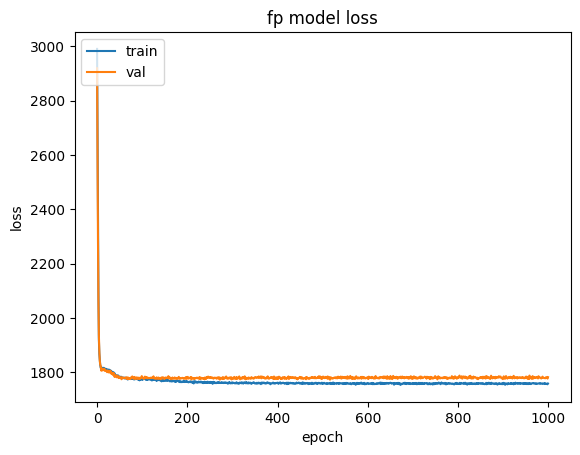

In [215]:
plt.plot(fpmodel_history.history['loss'])
plt.plot(fpmodel_history.history['val_loss'])
plt.title('fp model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model loss")
plt.show()

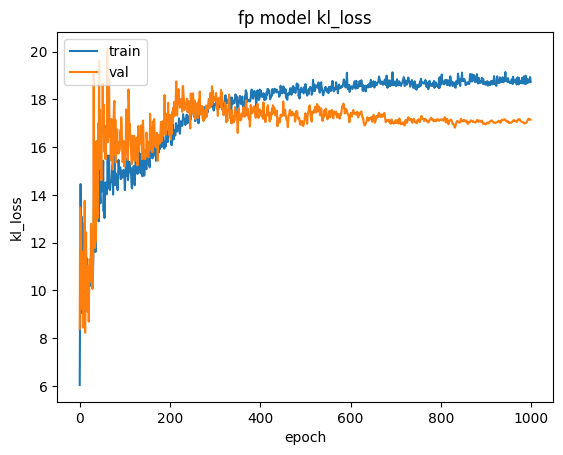

In [216]:
plt.plot(fpmodel_history.history['kl_loss'])
plt.plot(fpmodel_history.history['val_kl_loss'])
plt.title('fp model kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig("fp model loss")
plt.show()

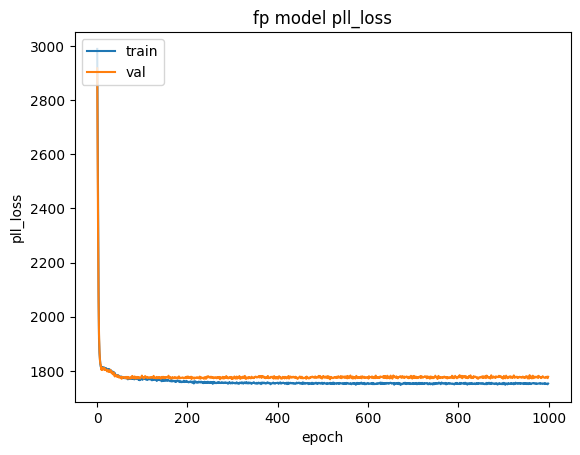

In [217]:
plt.plot(fpmodel_history.history['pll_loss'])
plt.plot(fpmodel_history.history['val_pll_loss'])
plt.title('fp model pll_loss')
plt.ylabel('pll_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model pll_")
plt.show()

In [218]:
pred_val_logf = model.predict([x_val, inputs2decoder_val])

In [219]:
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1772.1293, shape=(), dtype=float32)


# reload the best model

In [255]:
model.load_weights("guassian_lfadfp.h5")

In [256]:
pred_val_logf = model.predict([x_val, inputs2decoder_val])
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1772.0659, shape=(), dtype=float32)


/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [257]:
model.encoder.save("lfad_guassian_encoder.h5")

[17:04:29.702] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [258]:
model.decoder.save("lfad_guassian_decoder.h5")

[17:04:30.052] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


# Combine Encoder and Decoder

In [259]:
encoder_sample_in = encoder.inputs
encoder_sample_out = encoder.outputs[-1]

In [260]:
for l in model.decoder.layers:
    print(l)

## get decoder layers

In [261]:
decoder_latent_in, decocder_in = decoder.inputs
decoder_DecoderGRU = model.decoder.get_layer("DecoderGRU")
decoder_postdecoder_dropout = model.decoder.get_layer("postdecoder_dropout")
decoder_dense = model.decoder.get_layer("dense")                                                                                                      
decoder_nerual_dense = model.decoder.get_layer("nerual_dense")                                                                                                  

In [262]:
decoder_DecoderGRU_out = decoder_DecoderGRU(decocder_in, initial_state = encoder_sample_out)
decoder_postdecoder_dropout_out = decoder_postdecoder_dropout(decoder_DecoderGRU_out)
decoder_dense_out = decoder_dense(decoder_postdecoder_dropout_out)
decoder_nerual_dense_out = decoder_nerual_dense(decoder_dense_out)

In [263]:
lfads_full = Model(inputs = [encoder_sample_in, decocder_in], outputs = decoder_nerual_dense_out)

In [264]:
lfads_full.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

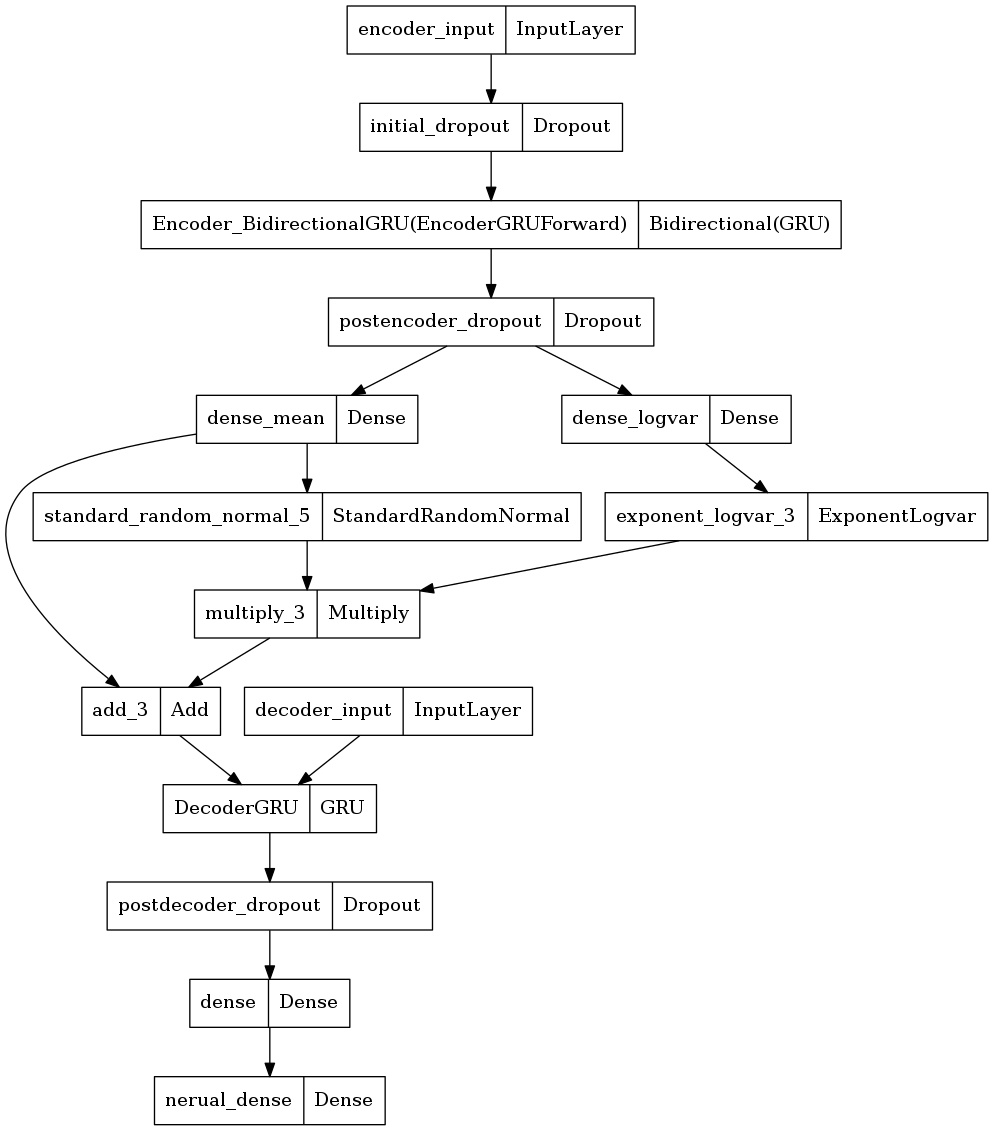

In [265]:
plot_model(lfads_full)

In [266]:
pred_val_logf = lfads_full.predict([x_val, inputs2decoder_val])
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1771.7437, shape=(), dtype=float32)


In [267]:
lfads_full.save("lfads_guassian_full_fpmodel.h5")

[17:04:35.790] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [268]:
from tensorflow.keras.models import load_model

In [269]:
custom_objects={
                "ExponentLogvar": ExponentLogvar,
                "StandardRandomNormal": StandardRandomNormal
               }

In [270]:
fmodel = load_model("lfads_guassian_full_fpmodel.h5", compile = False, custom_objects=custom_objects)

In [271]:
factors_layer = fmodel.get_layer("dense")
z_model = Model(fmodel.inputs,  factors_layer.output)
z_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [272]:
from sklearn.linear_model import Ridge

In [273]:
factors_reconstruct = np.arange(4)

In [274]:

z =  z_model.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('fpmodel train behaviour R2 score : {:.3%}'.format(r2))

0.8897259618757387
fpmodel train behaviour R2 score : 88.973%


/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [282]:
pred_z_test =  z_model.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print(reg.score(Xt, yt))

0.8333858921243407


/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
